# UKESM Temperature profile mask
The purpose of this notebook is to create a mask to remove all land based data points and Nans at a depth of 2000 m from the UKESM temperature data from historic simulations. To do this the notebook takes imports a prior mask calculated in v1.0.

The [mask calculation and creation](#Calculating-the-mask) can be found in the bottom half of the document.

TODO:
Plot masks in orthographic projection.

#### Dask Import

<br>

#### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#Ocean Area data for averaging
areaActivityId = 'CMIP'
areaVariableId = 'volcello'
areaSourceId = 'E3SM-1-0'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
importMaskName = "OceanMaskVolcello2"
idSel = 0 #Run Id selection
maxLat = -30
maxLev = 2000
timeSel = slice("2005-01","2014-12")

<br>

#### Imports

In [2]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from math import isnan
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [4]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

print(str(len(dfFilt))+" datasets found.")
dfFilt

3 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
207797,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190627
212795,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708
212889,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708


<br>
Ocean area data to be used for averaging

In [5]:
dfArea = df[df.activity_id.eq(areaActivityId) & df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

4 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
506320,CMIP,E3SM-Project,E3SM-1-0,piControl,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...,NaN,20210127
506325,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210127
506326,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128
506329,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128


<br>

#### Opening all datafiles
ESM3 data

In [6]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened and stored in fileSetList.")
else:
    print("No ESM3 data sets opened")

3 ESM3 data sets opened and stored in fileSetList.


<br>
Ocean Area data

In [7]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
print("Ocean Area data loaded and stored in dsArea")

Ocean Area data loaded and stored in dsArea


<br>
Previously generated ocean mask

In [8]:
maskFile = xr.open_dataset(importMaskName)
oceanMaskImport = maskFile.to_array()
print("Previously generated mask imported and stored in oceanMaskImport.")

Previously generated mask imported and stored in oceanMaskImport.


<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets
print("ESM data sets successfully merged from fileSetList into fileSet.")
#fileSet #Uncomment to see full data set

ESM data sets successfully merged from fileSetList into fileSet.


<br>

#### Selection of Data

In [10]:
dataFiltRT = fileSet.thetao.sel(RunID=idSel, time=timeSel) #Selection of latitude, level, run and time
dataFiltRTLat = dataFiltRT.where(dataFiltRT.latitude < maxLat, drop=True)
dataFiltFull = dataFiltRTLat.sel(lev=maxLev, method="nearest")
dataFiltFullM = dataFiltFull.mean("time", keep_attrs=True) #Dimension reduction by taking average over time
dataFiltFullM = dataFiltFullM.rename({"latitude":"lat", "longitude":"lon"})
#dataFiltFull = dataFiltFull.reset_coords(drop=True)
#dataFiltFullM = dataFiltFullM.reset_coords(drop=True) 

#dataAreaLevFilt = dsArea.volcello.sel(lat=latSel, lev=levSel)
#dataAreaLevFilt = dataAreaLevFilt.reset_coords(drop=True)

print("Finished data selection, ESM data filtered and stored in dataFiltFullM, volcello data filtered and stored in dataAreaLevFilt.\nUnaveraged ESM is stored in dataFiltFull.")
#dataFiltFullM #Uncomment to see filtered data set

Finished data selection, ESM data filtered and stored in dataFiltFullM, volcello data filtered and stored in dataAreaLevFilt.
Unaveraged ESM is stored in dataFiltFull.


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<br>

#### Time identification

In [11]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 2005-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
<b>Functions:</b><br>
convertToOne - Takes an input data set and returns a same dimensioned data set with values (int) 1 for all non Nan values (maximum input value magnitude 10^14). Is a delayed type.<br>
maskCalc - takes an input data set and returns a (int) 1 and "Nan" mask.<br>

In [12]:
@delayed
def convertToOne(dataSet):
    '''Takes in given dataSet and returns values of (int) 1 for all non Nan values (10^14 max value)'''
    dataSetModify = dataSet.copy()
    dataSetModify.values = dataSetModify.values/100000000000000 + 1
    dataSetModify = dataSetModify.astype(int)
    return dataSetModify


def maskCalc(LocData):
    '''Takes in a given data set and returns a data set of (int) 1 and Nan matching initial data set.'''
    mask = convertToOne(LocData)
    mask = mask.compute()
    maskNan = mask.where(mask.values == 1)
    return maskNan

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting functions
<b>Functions</b> <br>
mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number <br>

In [13]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
        subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def mapPlotScatter(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.scatter(x='lon',y='lat',transform=ccrs.PlateCarree(), c='values', cmap='bwr',
        subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def mapPlotScatterRec(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    fig = plt.figure(plotNo, figsize= (20,10))
    im = plt.scatter(x=dataSet['lon'],y=dataSet['lat'], c=dataSet.values, cmap='bwr')
    cbar = fig.colorbar(im)
    plt.title(str(title))
    
def maskPlotScatterRec(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    fig = plt.figure(plotNo, figsize= (20,10))
    im = plt.scatter(x=dataSet['lon'],y=dataSet['lat'], c=dataSet.values, cmap='brg', vmin=-1, vmax=1)
    cbar = fig.colorbar(im)
    plt.title(str(title))


print("Plotting functions defined")

Plotting functions defined


<br>

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


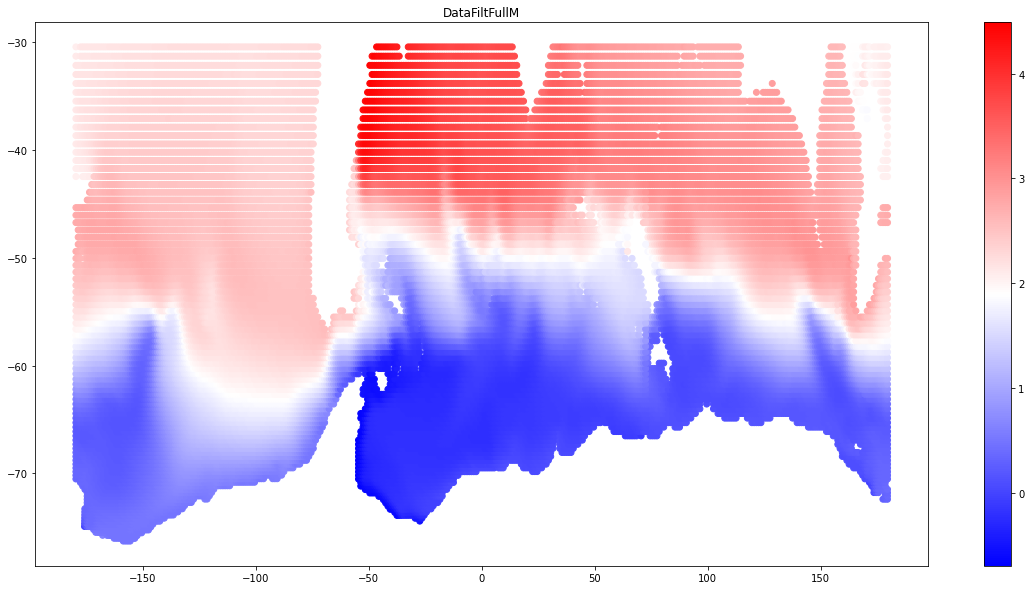

In [14]:
mapPlotScatterRec(dataFiltFullM, "DataFiltFullM", 1)

# Plot data of area and observe, generate mask

#### Calculating the mask

<b>Creating the mask</b><br>
Combining the filtered data with the imported mask

<br>
<b>Calculating the mask</b><br>

In [15]:
maskUKESMM = maskCalc(dataFiltFullM)
print("UKESM mean mask calculated for -2000.")

UKESM mean mask calculated for -2000.


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<br>
<b>Plotting volcello data and the created mask</b><br>

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


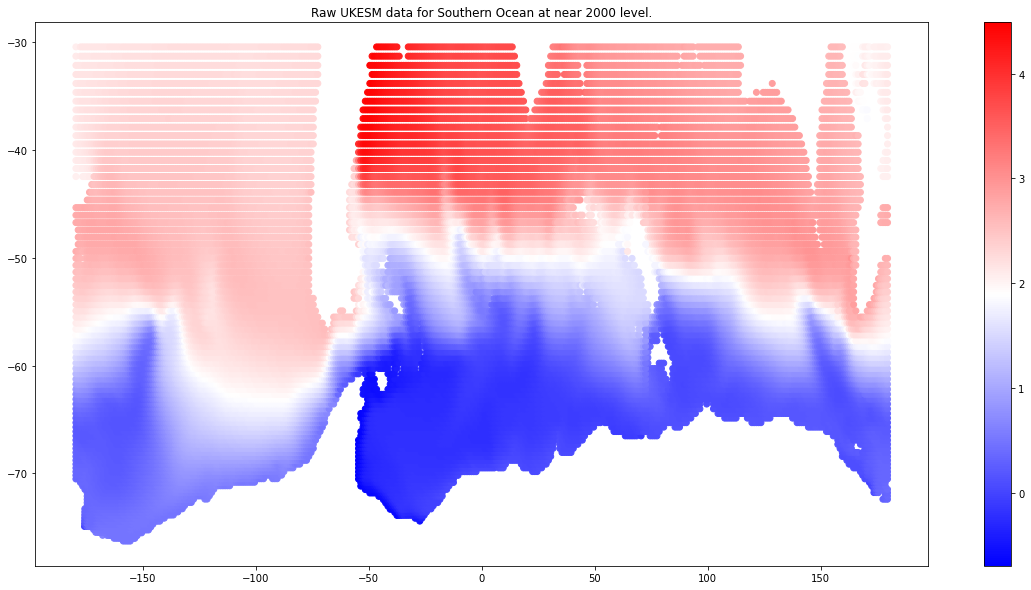

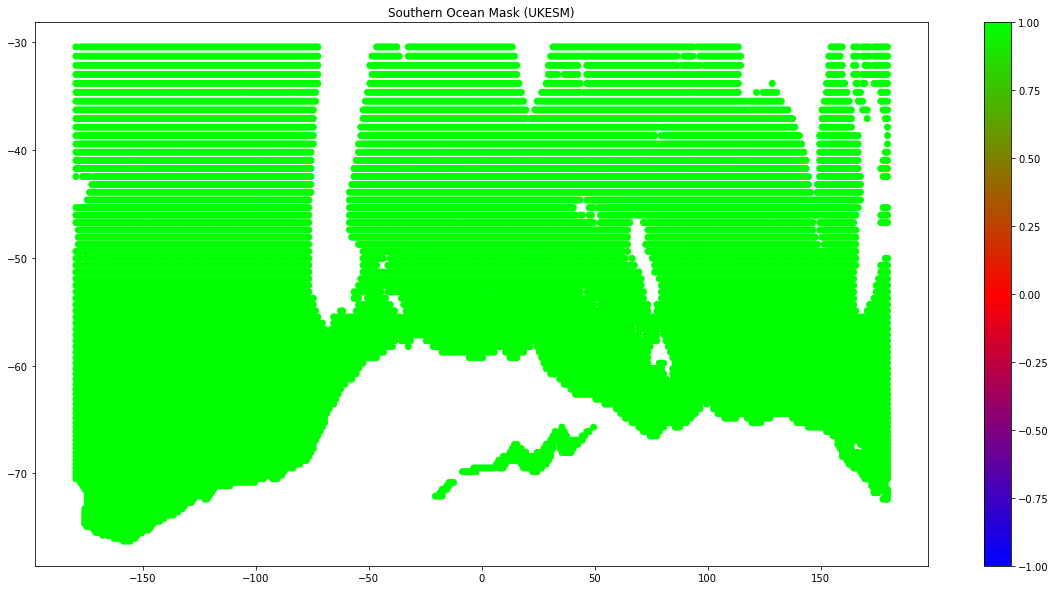

In [16]:
mapPlotScatterRec(dataFiltFullM, "Raw UKESM data for Southern Ocean at near 2000 level.", 1)
maskPlotScatterRec(maskUKESMM, "Southern Ocean Mask (UKESM)", 2)

<br>

#### Mask comparison

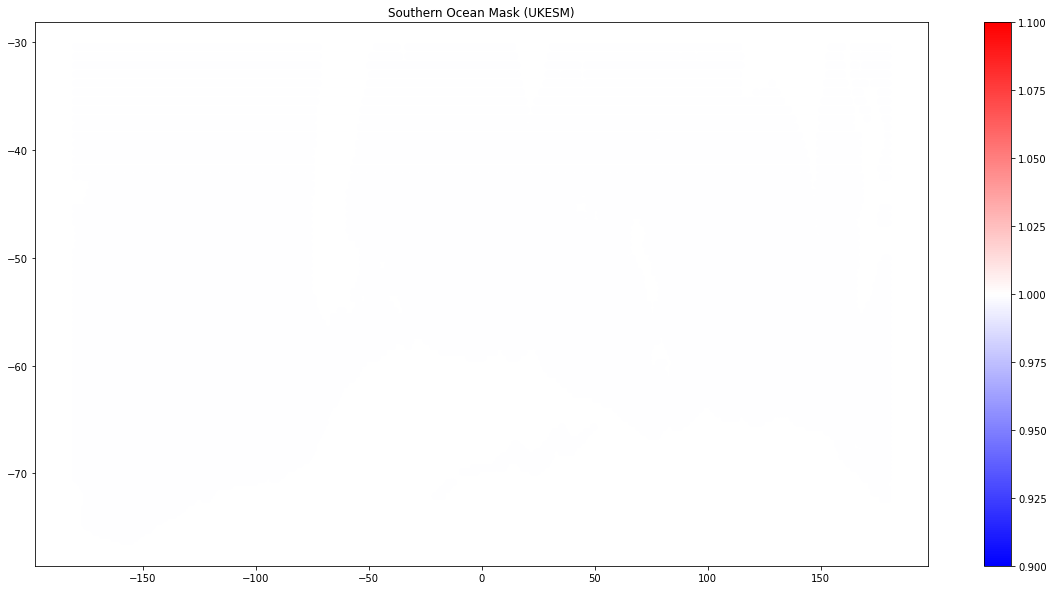

In [17]:
#mapPlot(oceanMaskImport, "Southern Ocean Mask (Imported)", 1)
mapPlotScatterRec(maskUKESMM, "Southern Ocean Mask (UKESM)", 1)

<br>

#### Saving and reloading the mask
<b>Saving the mask</b><br>

In [21]:
maskName = "OceanMaskUKESM"
maskUKESMM.to_netcdf(maskName)
print("Mask saved to "+maskName+".")

PermissionError: [Errno 13] Permission denied: b'/home/jovyan/Notebooks/Notebooks/OceanMaskUKESM'

<br>
<b>Reloading the mask</b><br>

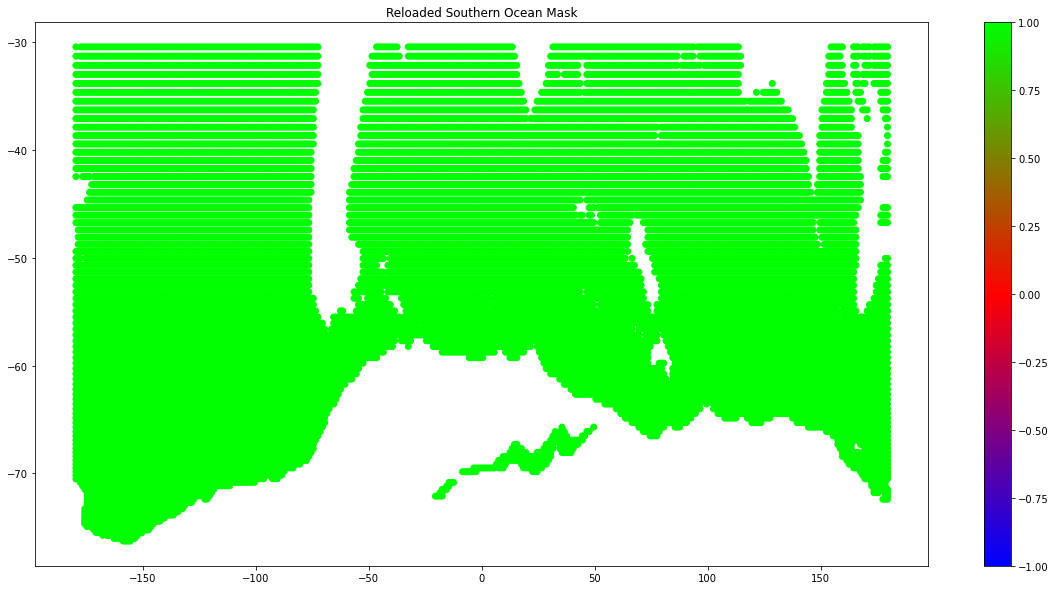

In [19]:
maskFile = xr.open_dataset(maskName)
oceanMaskReload = maskFile.to_array()
maskPlotScatterRec(oceanMaskReload, "Reloaded Southern Ocean Mask", 1)

<br>
<b>Checking mask dimensions</b>

In [20]:
print("Exported mask dims: ", maskUKESMM.dims)
print("Loaded mask dims: ", oceanMaskReload.dims)

Exported mask dims:  ('j', 'i')
Loaded mask dims:  ('variable', 'j', 'i')


<br>